In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
test = pd.read_csv('data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [4]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
595411,K.QELNEPPKQSTSFLVLQEILESEEKGDPNK.P,VYKMLQEKQELNEPP,EEKGDPNKPSGFRSV,QELNEPPKQSTSFLV,EILESEEKGDPNKPS,sp|O00151|PDLI1_HUMAN,QELNEPPKQSTSFLVLQEILESEEKGDPNK,0


In [5]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [6]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data_labelEnc(train)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data_labelEnc(val)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(543516, 39) (543516, 30) (543516, 15) (543516, 15) (543516, 15) (543516, 15) (543516,)
(135880, 39) (135880, 30) (135880, 15) (135880, 15) (135880, 15) (135880, 15) (135880,)
(133992, 39) (133992, 30) (133992, 15) (133992, 15) (133992, 15) (133992, 15) (133992,)


# Train

In [7]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*2)])
    except RuntimeError as e:
        print(e)

In [8]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# high param

In [9]:
from tensorflow import keras

In [10]:
# Embedding
pep = tf.keras.layers.Input(shape=((30,)))
pep_embed = tf.keras.layers.Embedding(21, 32, input_length=30, mask_zero=True)(pep)
pep_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_embed)

meta = tf.keras.layers.Input(shape=((39,)))  # peptide info

n = tf.keras.layers.Input(shape=((15,)))
n_embed = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(n)
n_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(n_embed)

c = tf.keras.layers.Input(shape=((15,)))
c_embed = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(c)
c_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(c_embed)

m1 = tf.keras.layers.Input(shape=((15,)))
m1_embed = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(m1)
m1_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m1_embed)

m2 = tf.keras.layers.Input(shape=((15,)))
m2_embed = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(m2)
m2_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m2_embed)


# LSTM
net_meta = tf.keras.layers.Dense(32, activation='relu')(meta)
net_meta = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_meta)

n_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(n_embed)
n_lstm = tf.keras.layers.Dense(8, activation='relu')(n_lstm)
n_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(n_lstm)

c_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(c_embed)
c_lstm = tf.keras.layers.Dense(8, activation='relu')(c_lstm)
c_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(c_lstm)

m1_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(m1_embed)
m1_lstm = tf.keras.layers.Dense(8, activation='relu')(m1_lstm)
m1_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m1_lstm)

m2_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(m2_embed)
m2_lstm = tf.keras.layers.Dense(8, activation='relu')(m2_lstm)
m2_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m2_lstm)

pep_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(pep_embed)
pep_lstm = tf.keras.layers.Dense(16, activation='relu')(pep_lstm)
pep_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_lstm)


# Dense
merge = tf.keras.layers.concatenate([pep_lstm, 
                                     net_meta,
                                     n_lstm,
                                     c_lstm,
                                     m1_lstm,
                                     m2_lstm])
net_merge = tf.keras.layers.Dense(64, activation='relu')(merge)
net_merge = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_merge)
net_merge = tf.keras.layers.Dense(32, activation='relu')(net_merge)
net_merge = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_merge)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net_merge)

model_high = tf.keras.Model(inputs=[pep, meta, n, c, m1, m2],
                            outputs=[output])

model_high.summary()

model_high.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=50)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 15)]         0                                            
______________________________________________________________________________________________

In [11]:
history = model_high.fit([pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=300,
                    batch_size=128,
                    validation_data=([pep_val, aa_val, en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es]
                        )

Epoch 1/300
4247/4247 [==============================] - 484s 107ms/step - loss: 3.0828 - accuracy: 0.5304 - val_loss: 0.5571 - val_accuracy: 0.7297
Epoch 2/300
4247/4247 [==============================] - 445s 105ms/step - loss: 0.5775 - accuracy: 0.7080 - val_loss: 0.5119 - val_accuracy: 0.7494
Epoch 3/300
4247/4247 [==============================] - 446s 105ms/step - loss: 0.5214 - accuracy: 0.7449 - val_loss: 0.4796 - val_accuracy: 0.7689
Epoch 4/300
4247/4247 [==============================] - 444s 105ms/step - loss: 0.4910 - accuracy: 0.7661 - val_loss: 0.4673 - val_accuracy: 0.7781
Epoch 5/300
4247/4247 [==============================] - 446s 105ms/step - loss: 0.4772 - accuracy: 0.7750 - val_loss: 0.4577 - val_accuracy: 0.7836
Epoch 6/300
4247/4247 [==============================] - 445s 105ms/step - loss: 0.4703 - accuracy: 0.7790 - val_loss: 0.4516 - val_accuracy: 0.7867
Epoch 7/300
4247/4247 [==============================] - 443s 104ms/step - loss: 0.4650 - accuracy: 0.7820

Epoch 56/300
4247/4247 [==============================] - 573s 135ms/step - loss: 0.4007 - accuracy: 0.8193 - val_loss: 0.3974 - val_accuracy: 0.8217
Epoch 57/300
4247/4247 [==============================] - 571s 134ms/step - loss: 0.3998 - accuracy: 0.8198 - val_loss: 0.3958 - val_accuracy: 0.8216
Epoch 58/300
4247/4247 [==============================] - 563s 133ms/step - loss: 0.3992 - accuracy: 0.8203 - val_loss: 0.3949 - val_accuracy: 0.8223
Epoch 59/300
4247/4247 [==============================] - 574s 135ms/step - loss: 0.3998 - accuracy: 0.8198 - val_loss: 0.3950 - val_accuracy: 0.8225
Epoch 60/300
4247/4247 [==============================] - 572s 135ms/step - loss: 0.3987 - accuracy: 0.8206 - val_loss: 0.3954 - val_accuracy: 0.8222
Epoch 61/300
4247/4247 [==============================] - 515s 121ms/step - loss: 0.3986 - accuracy: 0.8203 - val_loss: 0.3959 - val_accuracy: 0.8222
Epoch 62/300
4247/4247 [==============================] - 510s 120ms/step - loss: 0.3980 - accuracy:

4247/4247 [==============================] - 462s 109ms/step - loss: 0.3788 - accuracy: 0.8309 - val_loss: 0.3796 - val_accuracy: 0.8302
Epoch 165/300
4247/4247 [==============================] - 494s 116ms/step - loss: 0.3789 - accuracy: 0.8320 - val_loss: 0.3808 - val_accuracy: 0.8303
Epoch 166/300
4247/4247 [==============================] - 521s 123ms/step - loss: 0.3778 - accuracy: 0.8321 - val_loss: 0.3795 - val_accuracy: 0.8308
Epoch 167/300
4247/4247 [==============================] - 520s 122ms/step - loss: 0.3793 - accuracy: 0.8308 - val_loss: 0.3816 - val_accuracy: 0.8297
Epoch 168/300
4247/4247 [==============================] - 524s 123ms/step - loss: 0.3807 - accuracy: 0.8304 - val_loss: 0.3797 - val_accuracy: 0.8310
Epoch 169/300
4247/4247 [==============================] - 521s 123ms/step - loss: 0.3793 - accuracy: 0.8309 - val_loss: 0.3803 - val_accuracy: 0.8303
Epoch 170/300
4247/4247 [==============================] - 521s 123ms/step - loss: 0.3789 - accuracy: 0.8314

4247/4247 [==============================] - 506s 119ms/step - loss: 0.3698 - accuracy: 0.8363 - val_loss: 0.3750 - val_accuracy: 0.8337
Epoch 273/300
4247/4247 [==============================] - 461s 109ms/step - loss: 0.3700 - accuracy: 0.8356 - val_loss: 0.3758 - val_accuracy: 0.8332
Epoch 274/300
4247/4247 [==============================] - 471s 111ms/step - loss: 0.3699 - accuracy: 0.8362 - val_loss: 0.3741 - val_accuracy: 0.8335
Epoch 275/300
4247/4247 [==============================] - 474s 112ms/step - loss: 0.3696 - accuracy: 0.8368 - val_loss: 0.3743 - val_accuracy: 0.8333
Epoch 276/300
4247/4247 [==============================] - 461s 108ms/step - loss: 0.3702 - accuracy: 0.8357 - val_loss: 0.3742 - val_accuracy: 0.8334
Epoch 277/300
4247/4247 [==============================] - 463s 109ms/step - loss: 0.3712 - accuracy: 0.8359 - val_loss: 0.3748 - val_accuracy: 0.8334
Epoch 278/300
4247/4247 [==============================] - 466s 110ms/step - loss: 0.3698 - accuracy: 0.8357

In [12]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

4188/4188 [==============================] - 125s 30ms/step - loss: 0.3718 - accuracy: 0.8346
Test Loss: 0.37181878089904785
Test Accuracy: 0.834564745426178
              precision    recall  f1-score   support

           0       0.87      0.78      0.83     66996
           1       0.80      0.89      0.84     66996

    accuracy                           0.83    133992
   macro avg       0.84      0.83      0.83    133992
weighted avg       0.84      0.83      0.83    133992

rf auc : 0.9181441314466806


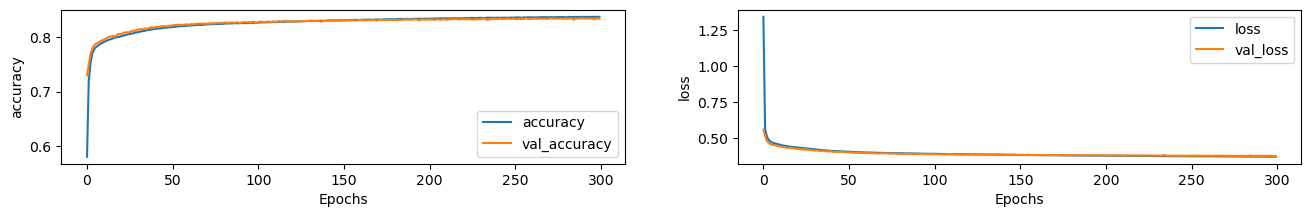

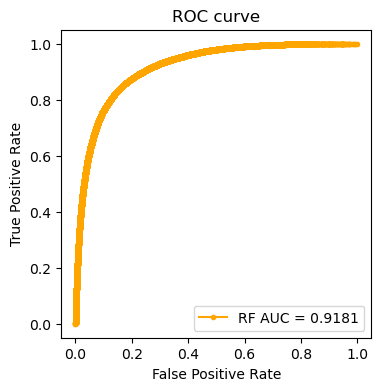

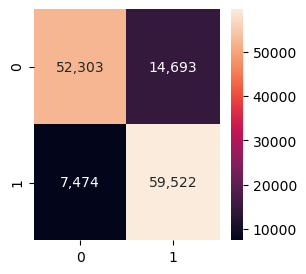

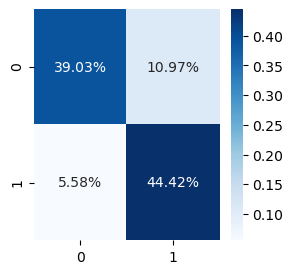

In [13]:
test_loss, test_acc = model_high.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [16]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model_high.save("compareModel/2021KSBi_multi")

INFO:tensorflow:Assets written to: compareModel/2021KSBi_multi/assets


INFO:tensorflow:Assets written to: compareModel/2021KSBi_multi/assets


In [17]:
# # It can be used to reconstruct the model identically.
model_high_re = tf.keras.models.load_model("compareModel/2021KSBi_multi")

4188/4188 [==============================] - 142s 31ms/step - loss: 0.3718 - accuracy: 0.8346
Test Loss: 0.37181878089904785
Test Accuracy: 0.834564745426178
              precision    recall  f1-score   support

           0       0.87      0.78      0.83     66996
           1       0.80      0.89      0.84     66996

    accuracy                           0.83    133992
   macro avg       0.84      0.83      0.83    133992
weighted avg       0.84      0.83      0.83    133992

rf auc : 0.9181441314466806


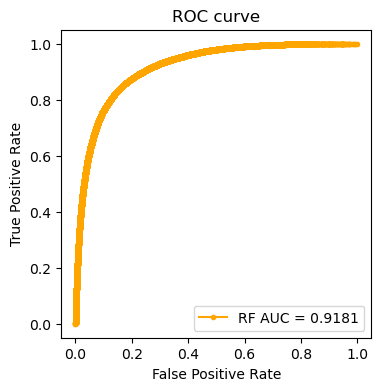

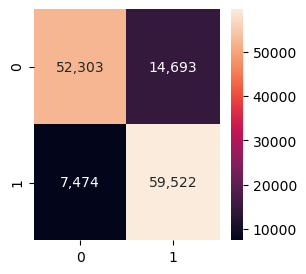

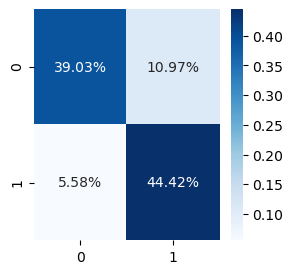

In [18]:
test_loss, test_acc = model_high_re.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high_re.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high_re.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high_re
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()